<a href="https://colab.research.google.com/github/marcusnk237/Binary-Classification-Cough-COVID/blob/main/Binary_classification_cough_COVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries


In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import csv
import itertools
import librosa

# Processing functions

## This function allows us to get negative and positive patients data path

In [ ]:
def prep_organize_data(POS_PATH, NEG_PATH, BASE_PATH): 

    #our data :-> Positive 
    pos_files = os.listdir(POS_PATH)
    base_path_pos = BASE_PATH + 'positive/'
    pos_data = [base_path_pos+x for x in pos_files]

    #our data :-> Negative
    neg_files = os.listdir(NEG_PATH)
    base_path_neg = BASE_PATH + 'negative/'
    neg_data = [base_path_neg+x for x in neg_files]

    #number of samples 
    tot_samples = len(neg_data) + len(pos_data)

    #fraction of samples 
    frac_pos = ((len(pos_data) / tot_samples)*100)
    frac_neg = ((len(neg_data) / tot_samples)*100)
    

    print(f"Number of Negative samples: {len(neg_data)} ({frac_neg:.2f}%)")
    print(f"Number of Positive samples: {len(pos_data)} ({frac_pos:.2f}%)\n")
    print(f"**** Total samples: {tot_samples} ****")
    
    return pos_files, pos_data, neg_files, neg_data

## This function allows us to extract the features of each signal. It's those we'll use for the classification

In [ ]:
def get_dataframe(dir_path='data'):
    '''
    Function which writes data to csv.
    Features it uses: 
    - RMSE 
    - Chroma STFT
    - Spectral Centroid
    - Spectral Bandwidth 
    - Spectral Rolloff 
    - Zero Crossing 
    Input: files in directory, 
    '''
    columns=['chroma_stft', 'rmse', 'spectral_centroid' ,'spectral_bandwidth', 'rolloff', 'zero_crossing_rate' ]
    for x in range(1,21):
        columns.append('mfcc'+str(x))
    columns.append('label')
    datas=[]
    results = ['negative','positive']
    for res in results: 
        for files in os.listdir(f"{dir_path}/{res}"):
            data=[]
            x, sr = librosa.load(f"{dir_path}/{res}/{files}", mono=True)
            data.append(np.mean(librosa.feature.chroma_stft(y=x, sr=sr)))            
            data.append(np.mean(librosa.feature.rms(y=x)))
            data.append(np.mean(librosa.feature.spectral_centroid(y=x, sr=sr)))
            data.append(np.mean(librosa.feature.spectral_bandwidth(y=x, sr=sr)))
            data.append(np.mean(librosa.feature.spectral_rolloff(y=x, sr=sr)))
            data.append(np.mean(librosa.feature.zero_crossing_rate(x)))
            mfcc = librosa.feature.mfcc(y=x, sr=sr)
            for k in mfcc:
                data.append(np.mean(k))
            data.append(results.index(res))
            datas.append(data)
            #print(data)
    return pd.DataFrame(datas, columns=columns)

## These functions allows us to evaluate a Neural Network model

In [ ]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalize confusion matrix")
    else:
        print('Confusion matrix')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Class')
    plt.xlabel('Predicted Class')

In [ ]:
def evaluate_model(history,X_test,y_test,model):
    #################### Evaluation  #########################
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Précision: %.2f%%" % (scores[1]*100))
    ##########################################################
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()

    prediction_proba=model.predict(X_test) # Get a prediction
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_test, prediction) # Compute the confusion matrix
    plot_confusion_matrix(cnf_matrix,['Negative','Positive'],True) # Plot the confusion matrix
    print(classification_report(y_test, prediction)) #Print classification report

## This function allows us to compute, compile and train an Artifical Neural Network for the cough classification

In [ ]:
def ann_model(X_train,y_train,X_test,y_test):
  model_1 = models.Sequential()
  model_1.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
  model_1.add(layers.Dense(128, activation='relu'))
  model_1.add(layers.Dense(64, activation='relu'))
  model_1.add(layers.Dense(10, activation='softmax'))
  #compiling
  model_1.compile(optimizer='adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
  model_1.summary()
  #fitting
  history = model_1.fit(X_train, y_train, epochs=30, batch_size=50, validation_data=(X_test, y_test))
  
  #evaluating
  return evaluate_model(history,X_test,y_test,model_1)

## This function allows us to compute, compile and train a Convolutionnal Neural Network for the cough classification

In [ ]:
def cnn_model(X_train,y_train,X_test,y_test):
  im_shape=(X_train.shape[1],1)
  inputs_cnn=layers.Input(shape=(im_shape), name='inputs_cnn')
  conv1_1= layers.Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
  conv1_1=layers.BatchNormalization()(conv1_1)
  pool1=layers.MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
  conv2_1=layers.Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
  conv2_1=layers.BatchNormalization()(conv2_1)
  pool2=layers.MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
  conv3_1=layers.Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
  conv3_1=layers.BatchNormalization()(conv3_1)
  pool3=layers.MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
  flatten=layers.Flatten()(pool3)
  dense_end1 = layers.Dense(64, activation='relu')(flatten)
  dense_end2 = layers.Dense(32, activation='relu')(dense_end1)
  main_output = layers.Dense(5, activation='softmax', name='main_output')(dense_end2)
  model = models.Model(inputs= inputs_cnn, outputs=main_output)
  #compiling 
  model.compile(optimizer='adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
  model.summary()
  #fitting
  history = model.fit(X_train, y_train, epochs=30, batch_size=50, validation_data=(X_test, y_test))
  #evaluating
  return evaluate_model(history,X_test,y_test,model)

# Main Program

## Downloading the dataset
We've uploaded the Coswada Dataset to our Kaggle account. To retrieve the dataset, we need :
* To download the kaggle librarie 
* Load our account's toke API
* And then, download the dataset, thanks to a specific command

### Downloading kaggle librarie and load the token API

In [ ]:
! pip install -q kaggle
########################

### Select kaggle.json file ##
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

### Downloading  and unzipping the dataset

In [ ]:
!kaggle datasets download -d marcjuniornkengue/coswara-dataset

In [ ]:
!unzip \*.zip  && rm *.zip

## Load datas and get it as a dataframe

In [ ]:
# Files path
POS_PATH = r"data/positive"
NEG_PATH = r"data/negative"
BASE_PATH = r"/data/"

In [ ]:
# Getting files by labels
pos_files, pos_data, neg_files, neg_data = prep_organize_data(POS_PATH, NEG_PATH, BASE_PATH)

In [ ]:
#columns for dataframe
cols = ["ID", "Result", "Age", "Gender", "Date", "Extra"]

#creating the dataframe
neg = pd.DataFrame([x.split("_") for x in neg_files])
pos = pd.DataFrame([x.split("_") for x in pos_files])

#joining and cleaning of datatypes
df = neg.append(pos)
df.columns = cols
df.drop(["Extra", "Date"],axis=1, inplace=True)
df['ID'] = df['ID'].astype('int')
df['Age'] = df['Age'].astype('int')

## Extract features of each signal and concatenate each result, to form a dataframe

In [ ]:
#Getting features dataframe
dataframe=get_dataframe()
dataframe

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.420121,0.056987,2460.253421,2142.163452,4942.972721,0.148935,-313.598846,75.936279,-22.711430,10.628294,-24.830627,10.148413,-10.734123,4.258841,-8.032422,-1.191433,-9.060747,-4.291999,-11.959909,-2.427130,-6.282333,1.267029,-3.951909,-6.495428,0.824463,-5.062700,0
1,0.493451,0.043425,1607.141664,1780.508243,3342.260742,0.067664,-376.684082,87.308479,-0.659219,26.159542,13.237623,17.780977,6.327206,1.287148,0.081539,12.964990,0.362261,-0.965118,1.588925,2.477184,1.165745,-3.045297,-2.453423,-1.917710,1.542274,2.879720,0
2,0.526096,0.020960,1466.898149,1749.936360,3151.476011,0.055406,-395.205353,84.737823,6.506432,29.080713,24.535204,12.014100,2.219259,5.087101,9.366309,9.036374,-0.310466,0.333262,3.585014,1.550782,0.853137,0.390993,0.746468,-2.264787,-0.584981,3.421058,0
3,0.546504,0.030731,1756.939071,1920.931232,3803.399291,0.069695,-391.126282,84.532143,-7.056905,33.715191,20.201569,20.771236,3.401362,4.628529,2.157515,11.390096,1.224412,0.403367,5.491997,3.340778,1.814354,-2.554027,-4.736024,-2.298580,-2.910229,0.922017,0
4,0.417148,0.045211,2369.938534,2067.716183,4717.735662,0.154040,-282.171326,88.513092,-18.037220,37.392307,-22.524454,13.067749,-14.626590,1.000359,-15.820086,-4.689546,-11.235810,-7.820345,-9.705928,-4.967413,-6.887034,-0.538527,-7.061100,-5.889076,-0.379377,-6.610066,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,0.381632,0.026565,1347.703365,1275.787465,2390.496720,0.082068,-323.778595,147.268173,-49.598457,17.329903,-22.742559,12.521058,-22.344965,-9.447893,-16.733234,-1.876830,4.072642,-8.039891,2.180070,-8.635007,4.361123,-9.769045,-8.152292,-9.872477,-0.676738,-4.816279,1
464,0.476008,0.041126,2506.155456,2187.111515,4981.314579,0.157578,-331.983704,70.998550,-13.308933,28.063318,-4.711559,11.674089,-13.809732,-1.129350,-15.711315,8.691145,-12.944974,-7.982398,-6.004486,1.378671,-10.473577,-1.294435,0.671947,-3.422073,2.079546,-2.399280,1
465,0.332854,0.081516,2398.824638,2375.896685,5428.729248,0.122486,-222.535889,89.102806,1.097372,18.015022,-14.275969,24.170101,-40.492626,-2.128169,-11.367053,-5.855387,-2.667337,-13.066000,-10.525891,-14.510655,-6.846966,-6.656900,-5.121770,-5.076474,-9.745247,-0.938128,1
466,0.381933,0.022074,1132.660997,1227.932867,2139.667013,0.060331,-351.045929,153.152405,-31.469082,28.840563,-24.621744,0.241343,-23.660152,-6.101599,-7.938265,-1.711930,-5.013205,-13.003090,3.841613,-9.260360,1.839960,-6.461794,-2.669506,-8.990814,-5.333156,-1.400745,1


## Shuffle the dataframe

In [ ]:
#since all the positives were first and negatives last, we shuffling the dataset
shuffle_df = dataframe.reindex(np.random.permutation(dataframe.index))
#labels
y = shuffle_df['label'].to_numpy()
#rest of data
X = (shuffle_df.iloc[:, :-1]).to_numpy()
shuffle_df

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
398,0.525485,0.030437,2161.047342,2140.215914,4607.507324,0.121669,-402.683746,54.063557,5.048339,13.172785,0.617132,10.379010,-12.402572,-9.198182,-8.088099,2.353312,-6.027960,-1.218173,2.785807,2.273397,-3.280498,-1.225106,0.657221,0.250097,-1.681844,1.050990,1
132,0.416465,0.135384,2184.115673,1805.475484,4021.991659,0.169766,-262.098511,74.078651,-35.239811,8.870378,-25.378141,0.288484,-22.989319,-6.924855,-15.403013,-2.512130,-4.327814,-3.282004,5.083090,4.158372,-4.597851,3.538777,2.008133,-0.571473,-1.149791,-0.511724,1
186,0.436434,0.050774,2927.740968,2324.331278,5710.994038,0.205684,-353.710693,53.091938,-12.141762,28.744955,-6.013068,6.103490,-25.852947,-1.253964,-25.436405,2.446791,-12.840587,-2.874911,-7.074098,8.542987,-7.196686,-6.937124,-4.445304,-1.333889,-7.416453,-3.461105,1
343,0.377493,0.025296,1460.922346,1482.201133,3100.286234,0.075987,-351.692810,111.569534,-29.578463,29.224007,-21.837666,18.333822,-18.622349,-6.900397,-11.460002,-8.799392,-2.736851,-10.663738,3.470113,-7.839859,0.105530,-10.720874,-1.021974,-4.664290,-2.485817,-1.073560,1
312,0.484688,0.055553,1539.511660,1785.990855,3215.625000,0.070514,-344.450928,83.860550,8.574414,39.458492,4.498399,9.046709,-0.722296,1.244420,2.268850,9.499941,1.810789,1.893989,7.341767,4.966273,0.188572,0.940022,1.397900,0.898906,-2.602751,0.400963,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,0.346471,0.075053,1594.287521,1788.665682,3218.801210,0.091298,-326.377289,96.350555,-0.435074,-0.243898,-10.889384,6.280961,-25.671562,-18.897062,-11.104018,2.034309,-14.911014,-12.063118,-11.301305,-7.635371,-6.388241,-9.155976,-6.318179,-4.812149,-2.500676,2.948922,1
369,0.419352,0.079132,2124.708734,2081.802394,4330.970348,0.125564,-259.647278,100.403397,0.121359,29.807030,-22.482033,11.720221,-16.454378,-0.089852,-17.751850,1.577942,-9.043355,-10.022969,-6.535619,-4.078776,-11.180730,-5.620266,-3.443089,-5.283877,-3.773770,0.880273,1
294,0.441301,0.016287,1415.750056,1383.366528,2727.055946,0.084470,-382.939667,122.303635,-30.508507,19.301344,-6.448402,-3.034847,-13.304284,-0.617111,-9.791396,-5.720545,-0.727115,-6.792377,4.587358,-5.353165,-0.471569,-4.901590,-1.689701,0.100969,0.240507,0.186858,1
62,0.485583,0.028970,2010.791641,2059.850510,4463.909912,0.121408,-359.322815,101.307457,-6.119389,6.778424,-16.664030,8.700208,-13.468796,3.180168,-12.013580,5.446046,-5.175678,-12.174314,-4.810565,-1.047558,-8.673403,-0.164709,-2.722101,-3.284391,-2.733114,1.962602,1


## Encoding data and split it into two datasets : train dataset and test dataset

In [ ]:
#instantiate the Label Encoder 
label_encoder = LabelEncoder()
#fit and transform the encoder 
y = label_encoder.fit_transform(y)

#instantiate scaler 
scaler = StandardScaler()
#fit transform scaler 
X = scaler.fit_transform(X)

#separating the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 256)               6912      
_________________________________________________________________
dense_33 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_35 (Dense)             (None, 10)                650       
Total params: 48,714
Trainable params: 48,714
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
8/8 [==============================] - 1s 25ms/step - loss: 1.5770 - accuracy: 0.6658 - val_loss: 0.5990 - val_accuracy: 0.9468
Epoch 2/30
8/8 [==============================] - 0s 5ms/step - loss: 0.5377 - accuracy: 0.9144 - val_loss: 0

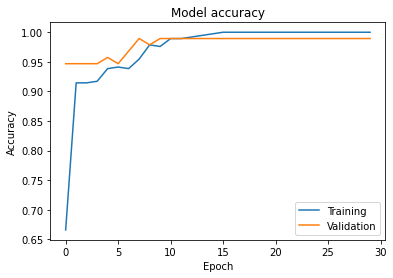

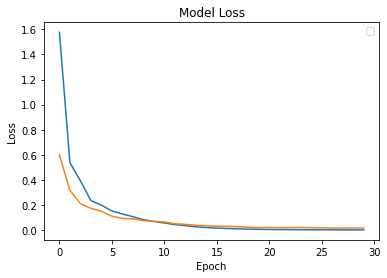

Normalize confusion matrix
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.99      1.00      0.99        89

    accuracy                           0.99        94
   macro avg       0.99      0.90      0.94        94
weighted avg       0.99      0.99      0.99        94



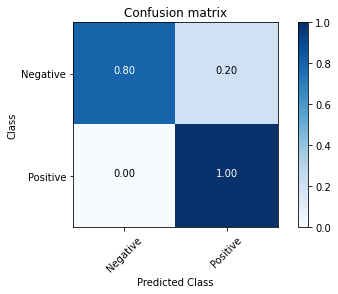

In [ ]:
ann_model(X_train,y_train,X_test,y_test)

## Compute, compile, train and evaluate each model

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_cnn (InputLayer)      [(None, 26, 1)]           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 21, 64)            448       
_________________________________________________________________
batch_normalization_12 (Batc (None, 21, 64)            256       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 11, 64)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 9, 64)             12352     
_________________________________________________________________
batch_normalization_13 (Batc (None, 9, 64)             256       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 5, 64)             0   

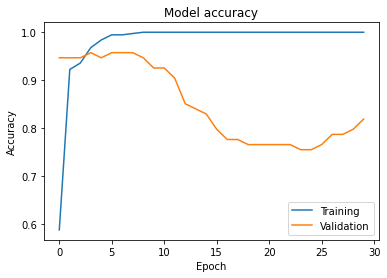

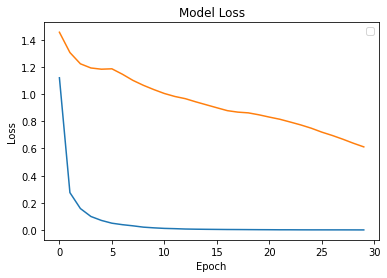

Normalize confusion matrix
              precision    recall  f1-score   support

           0       0.23      1.00      0.37         5
           1       1.00      0.81      0.89        89

    accuracy                           0.82        94
   macro avg       0.61      0.90      0.63        94
weighted avg       0.96      0.82      0.87        94



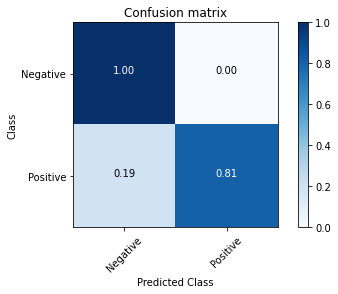

In [ ]:
cnn_model(X_train,y_train,X_test,y_test)